In [1]:
import numpy as np
import scipy.stats as st
import pandas as pd
import matplotlib.pyplot as plt

from context import probable_predicates
from probable_predicates import Predicate, BottomUp, StudentsT

In [2]:
np.random.seed(43414)

In [3]:
def generate_data(n, n_disc, disc_prior, n_cats_prior, n_cats_min, n_cont, cont_mean_scale, cont_mean_prior,
                  cont_var_alpha, cont_var_beta, val_mean, val_var):
    cont_vars = st.invgamma.rvs(cont_var_alpha, cont_var_beta, size=n_cont)
    cont_means = np.random.normal(cont_mean_prior, cont_vars/cont_mean_scale, size=n_cont)
    disc_cats = np.random.poisson(n_cats_prior, size=n_disc)+n_cats_min
    disc_probs = [np.random.dirichlet(disc_prior*np.ones(c)) for c in disc_cats]
    
    disc = np.array([np.random.choice(np.arange(len(d)), p=d, size=n) for d in disc_probs]).T
    cont = np.array([np.random.normal(cont_means[i], cont_vars[i], size=n)
                     for i in range(len(cont_means))]).T
    val = np.random.normal(val_mean, val_var, size=n)[:,None]

    disc_cols = [f'disc_{i}' for i in range(disc.shape[1])]
    cont_cols = [f'cont_{i}' for i in range(cont.shape[1])]
    val_cols = ['val']

    data = pd.DataFrame(np.hstack((val, disc, cont)), columns=val_cols + disc_cols + cont_cols)
    return data

In [4]:
data = generate_data(5000, 5, .8, 3, 2, 5, 1, 0, 1, 1, 0, 1)

In [5]:
ground_truth_predicate = Predicate(
    {'disc_0': [0], 'cont_0': [[-2, 0]]}, {'disc_0': 'discrete', 'cont_0': 'continuous'}
)

In [6]:
noise_mean = 10
noise_var = 3

In [7]:
noisy_data = data.copy()
query = ground_truth_predicate.query()
result = noisy_data.query(query)
noise = np.random.normal(noise_mean, noise_var, size=result.shape[0])
noisy_data.loc[result.index,'val'] += noise

In [8]:
model = StudentsT()
model.fit(noisy_data)

/Users/bmontambault/anaconda3/envs/forecasting/lib/python3.7/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -9,312.4, ||grad|| = 0.00012025: 100%|██████████| 13/13 [00:00<00:00, 1464.26it/s]  


In [9]:
dtypes = {col: {'disc':'discrete', 'cont':'continuous'}[col.split('_')[0]] for col in data.columns if col != 'val'}

In [10]:
search = BottomUp(noisy_data, dtypes, 'val', model)

In [11]:
predicate = search.search(binsize=100, penalty=.9, maxiters=2)

/Users/bmontambault/Desktop/repositories/probable_predicates/probable_predicates/search.py:40: RuntimeWarning: Mean of empty slice.
  new_loss = self.loss[new_data.index].mean()


In [12]:
predicate.fields

{'disc_0': [0.0], 'cont_0': [[-1.995328260349504, -0.05610904824411578]]}

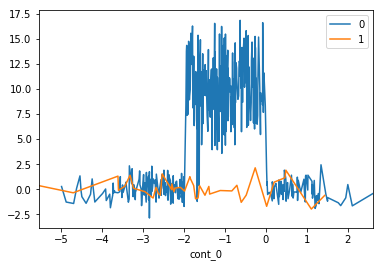

In [13]:
fig, ax = plt.subplots()
noisy_data[noisy_data.disc_0==0].sort_values('cont_0').plot(x='cont_0', y='val', ax=ax, label=0);
noisy_data[noisy_data.disc_0==1].sort_values('cont_0').plot(x='cont_0', y='val', ax=ax, label=1);